In [2]:
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten,Dropout
from keras.layers import Conv2D,LSTM,BatchNormalization,MaxPooling2D,Reshape
from keras.layers import Conv1D,Conv2D,BatchNormalization,MaxPooling2D,AveragePooling2D,Reshape,Permute,ELU, \
  TimeDistributed, LSTM, GRU, Bidirectional
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.constraints import max_norm

In [2]:
# For logging metrics to Weights and Biases Platform.
USING_WANDB = True  # Set to false if you don't have an account

if USING_WANDB:
    !pip install wandb &> /dev/null  # install wandb
    import wandb
    from wandb.keras import WandbMetricsLogger, WandbModelCheckpoint
    wandb.login()  # prompts for api key

ModuleNotFoundError: No module named 'wandb'

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

In [3]:
# Unzip data zip file
# !rm -r project_data
!unzip project_data.zip &> /dev/null
!rm -r __MACOSX
!mv project/* .
!rm -r project
# &> /dev/null  to quiet output

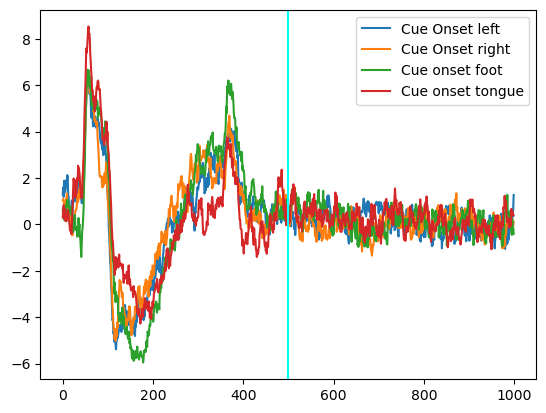

In [3]:
import numpy as np
path_prefix = "./project_data/project/"

X_test = np.load(path_prefix+"X_test.npy")
y_test = np.load(path_prefix+"y_test.npy")
person_train_valid = np.load(path_prefix+"person_train_valid.npy")
X_train_valid = np.load(path_prefix+"X_train_valid.npy")
y_train_valid = np.load(path_prefix+"y_train_valid.npy")
person_test = np.load(path_prefix+"person_test.npy")


## Adjusting the labels so that

# Cue onset left - 0
# Cue onset right - 1
# Cue onset foot - 2
# Cue onset tongue - 3

y_train_valid -= 769
y_test -= 769




## Visualizing the data

ch_data = X_train_valid[:,8,:]


class_0_ind = np.where(y_train_valid == 0)
ch_data_class_0 = ch_data[class_0_ind]
avg_ch_data_class_0 = np.mean(ch_data_class_0,axis=0)


class_1_ind = np.where(y_train_valid == 1)
ch_data_class_1 = ch_data[class_1_ind]
avg_ch_data_class_1 = np.mean(ch_data_class_1,axis=0)

class_2_ind = np.where(y_train_valid == 2)
ch_data_class_2 = ch_data[class_2_ind]
avg_ch_data_class_2 = np.mean(ch_data_class_2,axis=0)

class_3_ind = np.where(y_train_valid == 3)
ch_data_class_3 = ch_data[class_3_ind]
avg_ch_data_class_3 = np.mean(ch_data_class_3,axis=0)


plt.plot(np.arange(1000),avg_ch_data_class_0)
plt.plot(np.arange(1000),avg_ch_data_class_1)
plt.plot(np.arange(1000),avg_ch_data_class_2)
plt.plot(np.arange(1000),avg_ch_data_class_3)
plt.axvline(x=500, label='line at t=500',c='cyan')

plt.legend(["Cue Onset left", "Cue Onset right", "Cue onset foot", "Cue onset tongue"])

In [4]:
def train_data_prep(X,y,sub_sample,average,noise, cutoff):

    total_X = None
    total_y = None

    # Trimming the data (sample,22,1000) -> (sample,22,800)
    X = X[:,:,0:cutoff]
    print('Shape of X after trimming:',X.shape)

    # Maxpooling the data (sample,22,800) -> (sample,22,800/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)


    total_X = X_max
    total_y = y
    print('Shape of X after maxpooling:',total_X.shape)

    # Averaging + noise
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)

    # Data augmentation: increases number of samples (max pool and mean pool +noise)
    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))
    print('Shape of X after averaging+noise and concatenating:',total_X.shape)

    # Subsampling

    for i in range(sub_sample):

        X_subsample = X[:, :, i::sub_sample] + \
                            (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)

        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))


    print('Shape of X after subsampling and concatenating:',total_X.shape)
    print('Shape of Y:',total_y.shape)
    return total_X,total_y


# Don't increase the number of test samples
def test_data_prep(X, cutoff):

    total_X = None


    # Trimming the data (sample,22,1000) -> (sample,22,800)
    X = X[:,:,0:cutoff]
    print('Shape of X after trimming:',X.shape)

    # Maxpooling the data (sample,22,800) -> (sample,22,800/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, 2), axis=3)


    total_X = X_max
    print('Shape of X after maxpooling:',total_X.shape)

    return total_X

In [5]:
def preprocess(X_train_valid, y_train_valid, X_test, y_test, cutoff):
    num_train_valid = X_train_valid.shape[0]
    print(num_train_valid, " total train_val samples")

    valid_split = 0.2
    valid_count = int(num_train_valid * valid_split)

    # Train val split, then data augment the training set
    ind_valid = np.random.choice(X_train_valid.shape[0], valid_count, replace=False)

    ind_train = np.array(list(set(range(X_train_valid.shape[0])).difference(set(ind_valid))))
    # Creating the training and validation sets using the generated indices
    (x_train_unprocessed, x_valid) = X_train_valid[ind_train], X_train_valid[ind_valid]
    (y_train_unprocessed, y_valid) = y_train_valid[ind_train], y_train_valid[ind_valid]

    print("Augmenting train data")
    x_train, y_train = train_data_prep(x_train_unprocessed, y_train_unprocessed,2,2,True, cutoff)
    print("Augmenting val data")
    x_valid, y_valid = train_data_prep(x_valid, y_valid, 2, 2, True, cutoff)
    print("Augmenting test data")
    X_test_prep = test_data_prep(X_test, cutoff)


    # Old code with data leakage
    ## Preprocessing the dataset
    # X_train_valid_prep,y_train_valid_prep = train_data_prep(X_train_valid,y_train_valid,2,2,True)
    # X_test_prep = test_data_prep(X_test)
    # ## Random splitting and reshaping the data
    # # First generating the training and validation indices using random splitting
    # # 8460 is shape of num_samples after data augmentation
    # ind_valid = np.random.choice(8460, 1000, replace=False)
    # ind_train = np.array(list(set(range(8460)).difference(set(ind_valid))))
    # # Creating the training and validation sets using the generated indices
    # (x_train, x_valid) = X_train_valid_prep[ind_train], X_train_valid_prep[ind_valid]
    # (y_train, y_valid) = y_train_valid_prep[ind_train], y_train_valid_prep[ind_valid]
    print('Shape of training set:',x_train.shape)
    print('Shape of validation set:',x_valid.shape)
    print('Shape of training labels:',y_train.shape)
    print('Shape of validation labels:',y_valid.shape)


    # Converting the labels to categorical variables for multiclass classification
    y_train = to_categorical(y_train, 4)
    y_valid = to_categorical(y_valid, 4)
    y_test = to_categorical(y_test, 4)
    print('Shape of training labels after categorical conversion:',y_train.shape)
    print('Shape of validation labels after categorical conversion:',y_valid.shape)
    print('Shape of test labels after categorical conversion:',y_test.shape)

    # Adding width of the segment to be 1
    x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
    x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_valid.shape[2], 1)
    x_test = X_test_prep.reshape(X_test_prep.shape[0], X_test_prep.shape[1], X_test_prep.shape[2], 1)
    print('Shape of training set after adding width info:',x_train.shape)
    print('Shape of validation set after adding width info:',x_valid.shape)
    print('Shape of test set after adding width info:',x_test.shape)


    # Reshaping the training and validation dataset
    x_train = np.swapaxes(x_train, 1,3)
    x_train = np.swapaxes(x_train, 1,2)
    x_valid = np.swapaxes(x_valid, 1,3)
    x_valid = np.swapaxes(x_valid, 1,2)
    x_test = np.swapaxes(x_test, 1,3)
    x_test = np.swapaxes(x_test, 1,2)
    print('Shape of training set after dimension reshaping:',x_train.shape)
    print('Shape of validation set after dimension reshaping:',x_valid.shape)
    print('Shape of test set after dimension reshaping:',x_test.shape)
    # Note the dims of validation are diff than originally bc no longer data augment it

    return x_train, y_train, x_valid, y_valid, x_test, y_test


In [6]:

def get_data(cutoff):
    """Returns split and preprocessed data for both subject train and test (subject and rest)"""
    x_sub_train_val = X_train_valid
    y_sub_train_val = y_train_valid
    x_sub_test = X_test
    y_sub_test = y_test

    return preprocess(x_sub_train_val, y_sub_train_val, x_sub_test, y_sub_test, cutoff)


In [7]:
a,b,c,d,e,f = get_data(1000)
print(a.shape)
print(b.shape)
print(c.shape)
print(d.shape)
print(e.shape)
print(f.shape)

2115  total train_val samples
Augmenting train data
Shape of X after trimming: (1692, 22, 1000)
Shape of X after maxpooling: (1692, 22, 500)
Shape of X after averaging+noise and concatenating: (3384, 22, 500)
Shape of X after subsampling and concatenating: (6768, 22, 500)
Shape of Y: (6768,)
Augmenting val data
Shape of X after trimming: (423, 22, 1000)
Shape of X after maxpooling: (423, 22, 500)
Shape of X after averaging+noise and concatenating: (846, 22, 500)
Shape of X after subsampling and concatenating: (1692, 22, 500)
Shape of Y: (1692,)
Augmenting test data
Shape of X after trimming: (443, 22, 1000)
Shape of X after maxpooling: (443, 22, 500)
Shape of training set: (6768, 22, 500)
Shape of validation set: (1692, 22, 500)
Shape of training labels: (6768,)
Shape of validation labels: (1692,)
Shape of training labels after categorical conversion: (6768, 4)
Shape of validation labels after categorical conversion: (1692, 4)
Shape of test labels after categorical conversion: (443, 4)

## Train model with different cutoffs each time


In [9]:
all_result = {}

In [18]:
# Try isolating each subject
import json
from keras.layers import Input
lr = 1e-3
NUM_EPOCHS = 100
batch_size = 64
patience = 5  # 3
callbacks = []
callbacks.append(tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience))
criterion="categorical_crossentropy"
optimizer = keras.optimizers.Adam(learning_rate=lr)

for cutoff in range(1000,1100,100):
    print(f"Training on cutoff {cutoff}")
    x_sub_train, y_sub_train, x_sub_valid, y_sub_valid, x_sub_test, y_sub_test= get_data(cutoff)
    
    # SEED
    tf.keras.utils.set_random_seed(0)

    input_shape = (cutoff//2, 1, 22)
    num_units = 32 # 32
    num_hidden = 512 #16
    dropout_rate = 0.5  # TODO
    model = Sequential([
        # collapse the dim of 1
        Reshape((input_shape[0], input_shape[2]), input_shape=input_shape),
        Bidirectional(LSTM(num_units, return_sequences=True, input_shape=input_shape), input_shape=input_shape),
        # LSTM(32, return_sequences=True, input_shape=input_shape), # stateful=True
        # BatchNormalization(),
        # LSTM(32, return_sequences=True),
        # LSTM(16, return_sequences=True),
        # LSTM(num_units),  # batch_input_shape=(batch_size, look_back, 1)  # turn above to True is using
        # TimeDistributed(Dense(num_hidden, activation="relu")),  # return_sequences should be true above
        Flatten(),
        # Dense(num_hidden, activation="relu"),
        # Dropout(dropout_rate),
        Dense(4, activation="softmax")
        # bidirectional
        # doing return_sequences=True and Flatten() was much better than just return_sequences=False
    ])
    model.compile(loss=criterion, optimizer=optimizer, metrics=['accuracy'])

    # Training and validating the model
    model_results = model.fit(x_sub_train, y_sub_train,
                batch_size=batch_size,
                epochs=NUM_EPOCHS, callbacks=callbacks,
                validation_data=(x_sub_valid, y_sub_valid), verbose=1)  #, verbose=True)
    print(model_results)
    test_sub_acc = model.evaluate(x_sub_test, y_sub_test, verbose=0)
    print(f'Test acc of the subject : {test_sub_acc[1] : .4f}')
    
    all_result[cutoff] = {"train_acc_history": model_results.history["accuracy"], "val_acc_history": model_results.history["val_accuracy"]}
    json.dump(all_result, open("./results.json", "w"))

Training on cutoff 1000
2115  total train_val samples
Augmenting train data
Shape of X after trimming: (1692, 22, 1000)
Shape of X after maxpooling: (1692, 22, 500)
Shape of X after averaging+noise and concatenating: (3384, 22, 500)
Shape of X after subsampling and concatenating: (6768, 22, 500)
Shape of Y: (6768,)
Augmenting val data
Shape of X after trimming: (423, 22, 1000)
Shape of X after maxpooling: (423, 22, 500)
Shape of X after averaging+noise and concatenating: (846, 22, 500)
Shape of X after subsampling and concatenating: (1692, 22, 500)
Shape of Y: (1692,)
Augmenting test data
Shape of X after trimming: (443, 22, 1000)
Shape of X after maxpooling: (443, 22, 500)
Shape of training set: (6768, 22, 500)
Shape of validation set: (1692, 22, 500)
Shape of training labels: (6768,)
Shape of validation labels: (1692,)
Shape of training labels after categorical conversion: (6768, 4)
Shape of validation labels after categorical conversion: (1692, 4)
Shape of test labels after categori

2024-03-15 04:09:26.740157: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-15 04:09:26.740808: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-15 04:09:26.741592: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/100


2024-03-15 04:09:27.188882: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-15 04:09:27.191170: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-15 04:09:27.193975: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

106/106 [==============================] - ETA: 0s - loss: 0.6355 - accuracy: 0.7762

2024-03-15 04:09:39.517876: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-15 04:09:39.518883: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-15 04:09:39.519484: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

106/106 [==============================] - 14s 116ms/step - loss: 0.6355 - accuracy: 0.7762 - val_loss: 1.4644 - val_accuracy: 0.4657
Epoch 2/100
106/106 [==============================] - 12s 115ms/step - loss: 0.0313 - accuracy: 0.9985 - val_loss: 1.5488 - val_accuracy: 0.4752
Epoch 3/100
106/106 [==============================] - 12s 113ms/step - loss: 0.0104 - accuracy: 1.0000 - val_loss: 1.6121 - val_accuracy: 0.4846
Epoch 4/100
106/106 [==============================] - 14s 132ms/step - loss: 0.0064 - accuracy: 1.0000 - val_loss: 1.6534 - val_accuracy: 0.4900
Epoch 5/100
106/106 [==============================] - 14s 136ms/step - loss: 0.0045 - accuracy: 1.0000 - val_loss: 1.6928 - val_accuracy: 0.4911
Epoch 6/100
106/106 [==============================] - 15s 143ms/step - loss: 0.0034 - accuracy: 1.0000 - val_loss: 1.7361 - val_accuracy: 0.4941
Test acc of the subject :  0.5237


## Visualization of Results

### Load result

If you already have the results saved in Json, you can load with code

In [19]:
import json
SAVED = True

all_result = {}

if SAVED:
    temp_result = json.load(open("./results.json","r"))
    for i in temp_result.keys():
        all_result[int(i)] = temp_result[i]
print(all_result)

{100: {'train_acc_history': [0.4831560254096985, 0.7002068758010864, 0.8107269406318665, 0.8788415789604187, 0.9278959631919861, 0.9571512937545776, 0.9734042286872864], 'val_acc_history': [0.42198580503463745, 0.4509456157684326, 0.4692671298980713, 0.46690306067466736, 0.4645390212535858, 0.4621749520301819, 0.47104018926620483]}, 200: {'train_acc_history': [0.6152482032775879, 0.9284870028495789, 0.9881796836853027, 0.9983747005462646, 1.0, 1.0], 'val_acc_history': [0.44680851697921753, 0.4822694957256317, 0.4929077923297882, 0.4799054265022278, 0.4964539110660553, 0.5011820197105408]}, 300: {'train_acc_history': [0.6740543842315674, 0.978723406791687, 0.9991135001182556, 1.0, 1.0, 1.0], 'val_acc_history': [0.47340425848960876, 0.4905437231063843, 0.5, 0.49763593077659607, 0.49408984184265137, 0.4970449209213257]}, 400: {'train_acc_history': [0.6969562768936157, 0.986997663974762, 0.9998522400856018, 1.0, 1.0, 1.0], 'val_acc_history': [0.4722222089767456, 0.5041370987892151, 0.50650

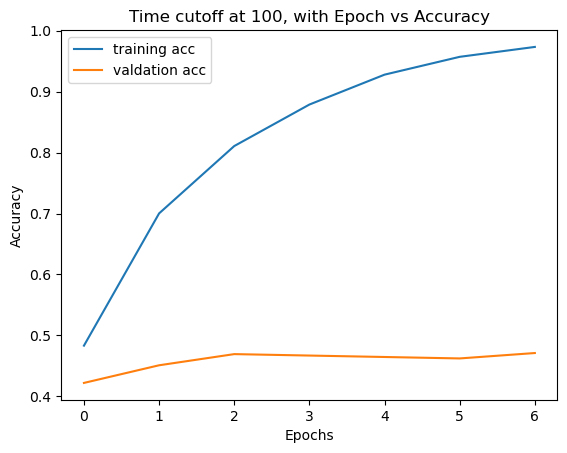

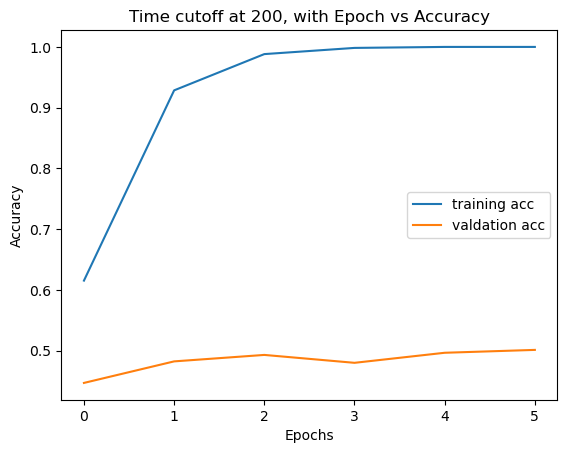

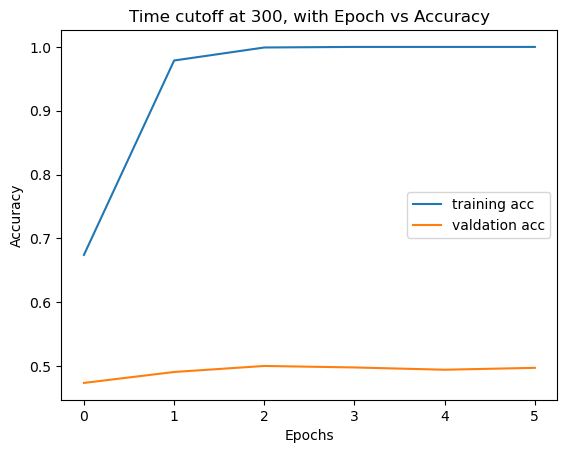

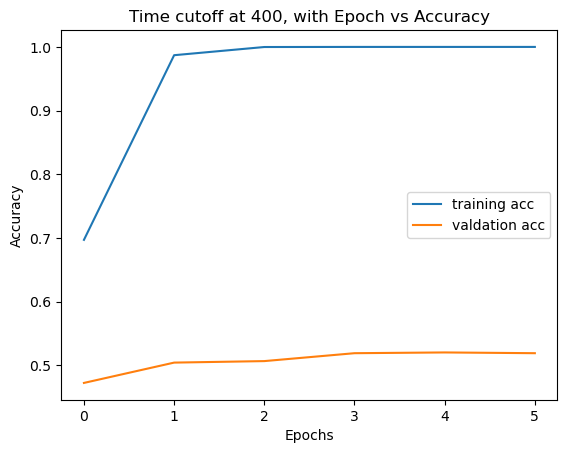

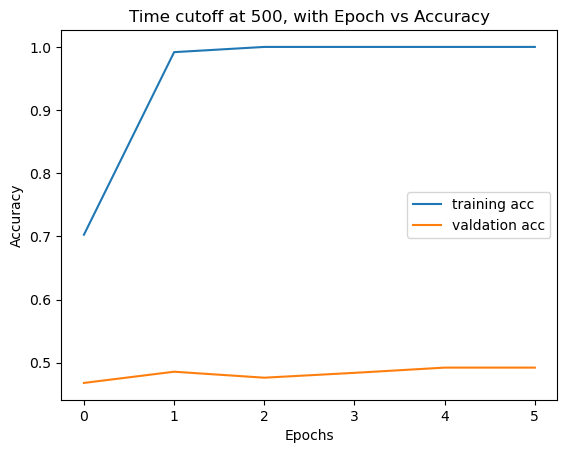

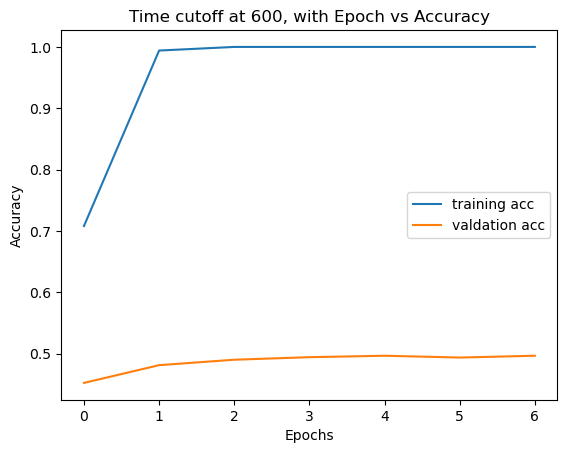

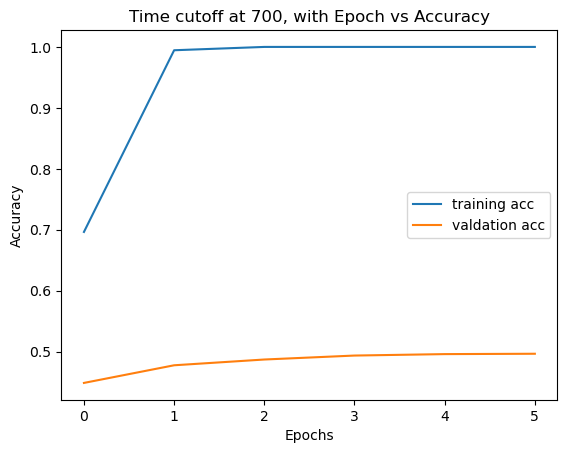

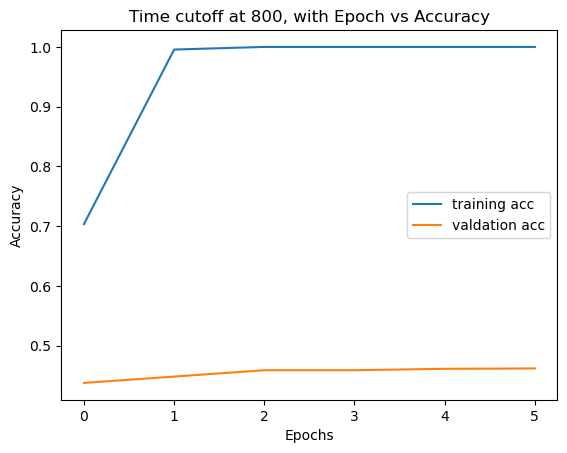

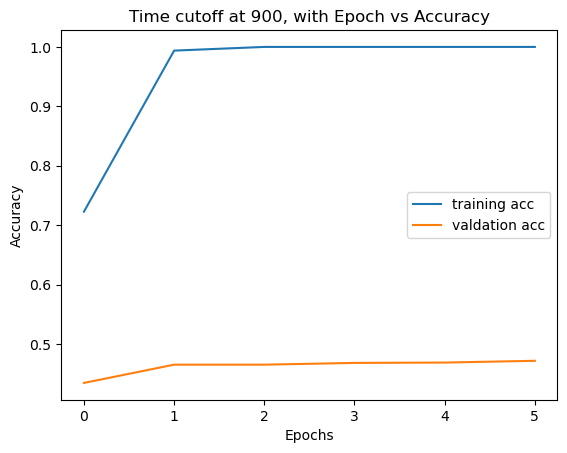

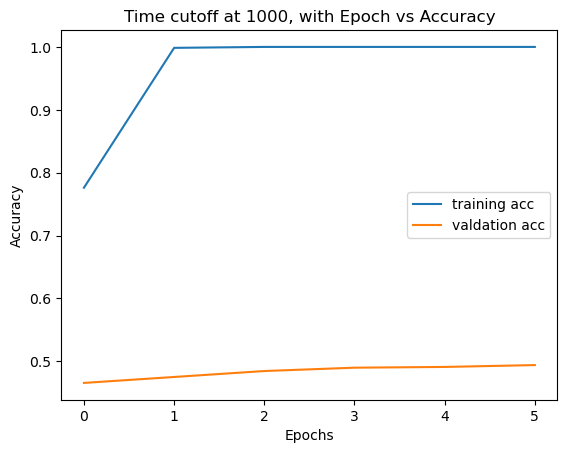

In [20]:
from matplotlib import pyplot as plt
for i in sorted(all_result.keys()):
    plt.plot(all_result[i]["train_acc_history"], label='training acc')
    plt.plot(all_result[i]["val_acc_history"], label='valdation acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title("Time cutoff at " + str(i) + ", with Epoch vs Accuracy")
    plt.legend()
    plt.show()

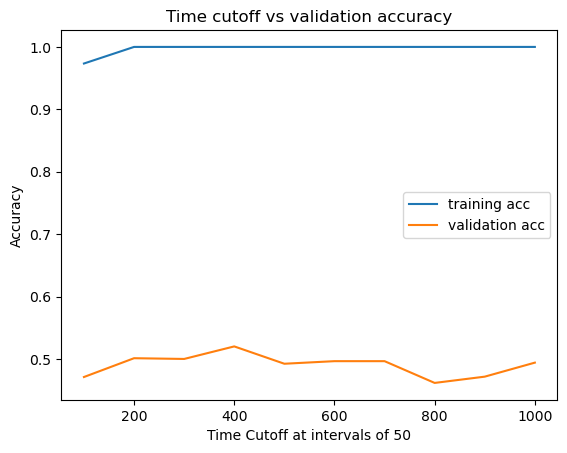

In [21]:
from matplotlib import pyplot as plt

max_val = []
max_train = []

for i in sorted(all_result.keys()):
    max_val.append(max(all_result[i]["val_acc_history"]))
    max_train.append(max(all_result[i]["train_acc_history"]))

plt.plot(sorted(all_result.keys()), max_train, label='training acc')
plt.plot(sorted(all_result.keys()), max_val, label='validation acc')
plt.xlabel('Time Cutoff at intervals of 50')
plt.ylabel('Accuracy')
plt.title("Time cutoff vs validation accuracy")
plt.legend()
plt.show()

In [22]:
from texttable import Texttable
t = Texttable()
res = [['Time Cutoff', 'Max Val Acc (epoch granularity)', 'Max Train Acc (epoch granularity)', 'Min Val Acc (epoch granularity)', 'Min Train Acc (epoch granularity)']]
for i in sorted(all_result.keys()):
    res.append([str(i), max(all_result[i]["val_acc_history"]),
                max(all_result[i]["train_acc_history"]),
                min(all_result[i]["val_acc_history"]),
                min(all_result[i]["train_acc_history"])
               ])
t.add_rows(res)
print(t.draw())

+-------------+----------------+---------------+---------------+---------------+
| Time Cutoff |  Max Val Acc   | Max Train Acc |  Min Val Acc  | Min Train Acc |
|             |     (epoch     |    (epoch     |    (epoch     |    (epoch     |
|             |  granularity)  | granularity)  | granularity)  | granularity)  |
+=============+================+===============+===============+===============+
| 100         | 0.471          | 0.973         | 0.422         | 0.483         |
+-------------+----------------+---------------+---------------+---------------+
| 200         | 0.501          | 1             | 0.447         | 0.615         |
+-------------+----------------+---------------+---------------+---------------+
| 300         | 0.500          | 1             | 0.473         | 0.674         |
+-------------+----------------+---------------+---------------+---------------+
| 400         | 0.520          | 1             | 0.472         | 0.697         |
+-------------+-------------